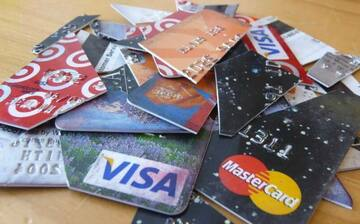

## Dataset Information

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

* A XGBoost model is built to predict if a client will default on next payment, **final auc: 0.793**

In [6]:
import numpy as np 
import pandas as pd 

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
credit_card = pd.read_csv('../input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

credit_card.drop(columns='ID', inplace=True) # drop ID, as this is irrelevant

credit_card.rename(columns={'default.payment.next.month':'default'}, inplace=True)

In [51]:
credit_card.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    20000.0    2          2         1   24      2      2     -1     -1   
1   120000.0    2          2         2   26     -1      2      0      0   
2    90000.0    2          2         2   34      0      0      0      0   
3    50000.0    2          2         1   37      0      0      0      0   
4    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1      0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2      0  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3      0  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4      0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0       0.0       0.0       0.0        1  
1    1000.0       0.0    2000.0        1  
2    1000.0    1000.0    5000.0        0  
3    1100.0    1069.0    1000.0        0  
4    9000.0     689.0     679.0        0  

[5 rows x 24 columns]

In [9]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [10]:
credit_card.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6       default  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 24 columns]

## There are 25 variables:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

## There are no missing values

In [11]:
credit_card.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

# EDA

Data is not very balanced, there are way more `non-default` than `default`

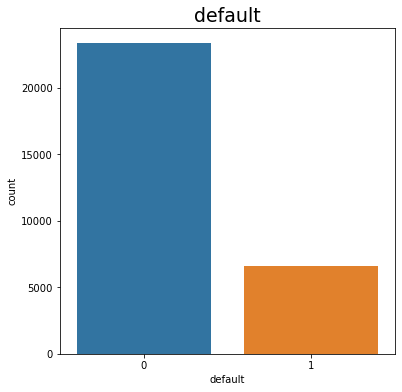

In [12]:
# count 

plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default')
plt.title('default', size=19)
plt.show()

In [13]:
print('non-default:', len(credit_card.default) - sum(credit_card.default))
print('default:', sum(credit_card.default))

non-default: 23364
default: 6636


SEX: Gender (1=male, 2=female)

For `non-default`, there are more female than male

For `default`, there are slightly more female than male

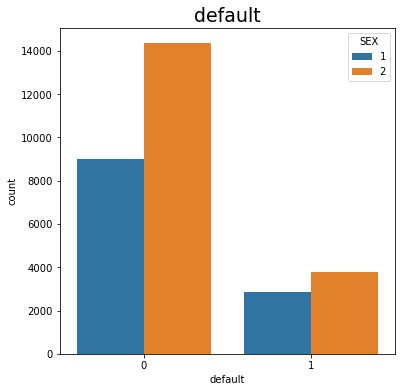

In [14]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='SEX')
plt.title('default', size=19)
plt.show()

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

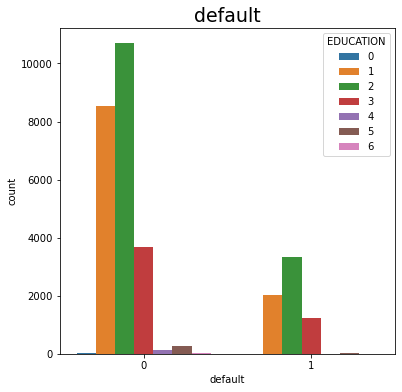

In [15]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='EDUCATION')
plt.title('default', size=19)
plt.show()

MARRIAGE: Marital status (1=married, 2=single, 3=others)

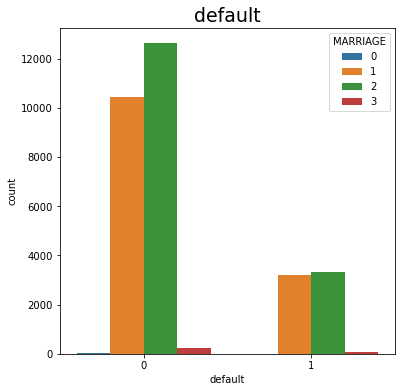

In [16]:
plt.figure(figsize=(6,6))
sns.countplot(data=credit_card, x='default', hue='MARRIAGE')
plt.title('default', size=19)
plt.show()

Age

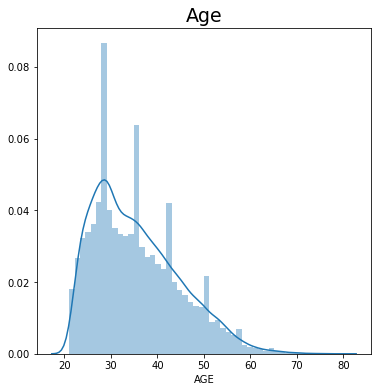

In [17]:
plt.figure(figsize=(6,6))
sns.distplot(credit_card.AGE)
plt.title('Age', size=19)
plt.show()

default vs age

distrbution of age between the two classes showed not much of difference

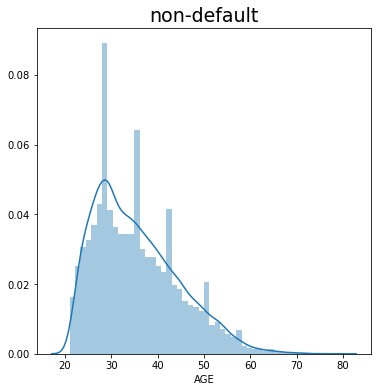

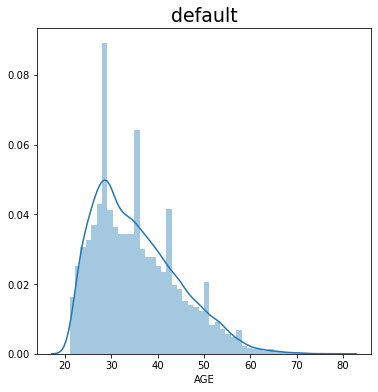

In [18]:
non_default = credit_card.loc[credit_card.default == 0]
default = credit_card.loc[credit_card.default == 1]

plt.figure(figsize=(6,6))
sns.distplot(non_default.AGE)
plt.title('non-default', size=19)
plt.show()

plt.figure(figsize=(6,6))
sns.distplot(non_default.AGE)
plt.title('default', size=19)
plt.show()

# XGBoost

In [19]:
cc = credit_card.copy()

# base X and y
y = cc.iloc[:,-1]
X = cc.iloc[:,0:-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (24000, 23)
x_test: (6000, 23)
y_train: (24000,)
y_test: (6000,)


In [20]:
# proportion of 0 and 1 in train/test, just to make sure train and test had same distribution

print(y_train.value_counts()/len(y_train))
print('\n')
print(y_test.value_counts()/len(y_test))

0    0.778375
1    0.221625
Name: default, dtype: float64


0    0.7805
1    0.2195
Name: default, dtype: float64


## set `scale_pos_weight`

The data is imbalanced, so we need to set `scale_pos_weight`, from EDA:

* non-default: 23364
* default: 6636

so preliminary `scale_pos_weight` = 23364/6636 = 3.52

In [52]:
model = XGBClassifier(scale_pos_weight=3.52, eval_metric='auc')
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3.52, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [53]:
pred = model.predict_proba(x_test)
roc_auc_score(y_test, pred[:,1])

0.765963449436896

# Hyperparameter Tuning

## Tune `scale_pos_weight`

best cv score: 0.7641200092121778 {'scale_pos_weight': 3.65}

best cv score: 0.7641200092121778 {'scale_pos_weight': 3.65}
0.762528, (0.006812),{'scale_pos_weight': 3.45}
0.761942, (0.008473),{'scale_pos_weight': 3.5}
0.763141, (0.007700),{'scale_pos_weight': 3.55}
0.761479, (0.009446),{'scale_pos_weight': 3.6}
0.764120, (0.008482),{'scale_pos_weight': 3.65}


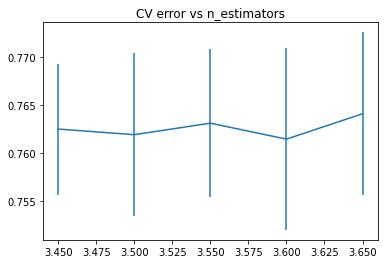

In [56]:
# tune scale_pos_weight

model = XGBClassifier()

scale_pos_weight = [3.45, 3.5, 3.55, 3.6, 3.65]
param = dict(scale_pos_weight = scale_pos_weight)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
grid_result = grid_search.fit(X, y)

print('best cv score:', grid_result.best_score_, grid_result.best_params_)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print('%f, (%f),%r' % (mean, std, param))

plt.errorbar(scale_pos_weight, means, yerr=stds)
plt.title('CV error vs n_estimators')
plt.show()

## Tune `n_estimator`

best cv score: 0.7711229012960673 {'n_estimators': 50}

In [24]:
# # tune n_estimator

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # n_estimators : 50 ~ 400
# n_estimators = range(50, 400, 50)
# param = dict(n_estimators = n_estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(n_estimators, means, yerr=stds)
# plt.title('CV error vs n_estimators')
# plt.show()

## Tune `max_depth`

best cv score: 0.7791281026402791 {'max_depth': 3}

In [25]:
# # tune tree size

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # tree depth = 1,3,5,7,9
# max_depth = [1,3,5,7,9]
# param = dict(max_depth = max_depth)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(max_depth, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## Tune `learning_rate`

best cv score: 0.7814509434904099 {'learning_rate': 0.05}

In [26]:
# # tune learning rate

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate
# learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
# param = dict(learning_rate = learning_rate)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(learning_rate, means, yerr=stds)
# plt.title('CV error vs learning rate')
# plt.show()

## searching for best combination of `n_estimators` and `learning_rate`

best cv score: 0.7816162765619434 {'learning_rate': 0.01, 'n_estimators': 400}

0.781182, (0.009172),{'learning_rate': 0.01, 'n_estimators': 300}

0.781451, (0.008836),{'learning_rate': 0.05, 'n_estimators': 100}

In [27]:
# # tune learning rate and n_estimator

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate and n_estimator
# learning_rate = [0.005, 0.01, 0.05, 0.1, 0.2]
# n_estimators = [50, 100, 200, 300, 400]
# param = dict(learning_rate = learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))



## Tuning Stochastic Gradient Boosting

## row subsampling

est cv score: 0.7641200092121778 {'subsample': 1.0}

using all the rows

In [28]:
# # row sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# # learning rate and n_estimator
# subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(subsample = subsample)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(subsample, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## column subsampling before creating a tree

best cv score: 0.7664118466032764 {'colsample_bytree': 0.2}

In [29]:
# # tune column sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(colsample_bytree = colsample_bytree)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(colsample_bytree, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## column subsampling for each split in a tree

best cv score: 0.7689689215616526 {'colsample_bylevel': 0.1}

In [30]:
# # tune column sub sampling

# model = XGBClassifier(scale_pos_weight=3.65, eval_metric='auc')

# colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
# param = dict(colsample_bylevel = colsample_bylevel)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# plt.errorbar(colsample_bylevel, means, yerr=stds)
# plt.title('CV error vs max_depth')
# plt.show()

## Hyperparameter Tuning, Part 2

combining all the results from above

best cv score: 0.7815174509656737 {'colsample_bytree': 0.4, 'learning_rate': 0.06, 'max_depth': 3, 'min_child_weight': 1.8}

In [31]:
# # tuning all parameters togather

# model = XGBClassifier(n_estimators=100, scale_pos_weight=3.65, eval_metric='auc')

# learning_rate = [0.04, 0.045, 0.05, 0.055, 0.06]
# max_depth = [2, 3]
# colsample_bytree = [0.2, 0.3, 0.4, 0.5]
# min_child_weight = [1, 1.8, 2.0, 2.2]
# param = dict(learning_rate=learning_rate, max_depth = max_depth, colsample_bytree=colsample_bytree, min_child_weight=min_child_weight)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(model, param, scoring='roc_auc', n_jobs = -1, cv=kfold)
# grid_result = grid_search.fit(X, y)

# print('best cv score:', grid_result.best_score_, grid_result.best_params_)

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, std, param in zip(means, stds, params):
#     print('%f, (%f),%r' % (mean, std, param))

# Final Model

Using the results from all the hyperparameter tuning from above, the final auc is 0.793

In [57]:
# final model
model = XGBClassifier(n_estimators=100, learning_rate=0.06, colsample_bytree=0.4, max_depth=3, min_child_weight=1.8,scale_pos_weight=3.65 )
model.fit(x_train, y_train)

pred = model.predict_proba(x_test)
print('auc:', roc_auc_score(y_test, pred[:,1]))


auc: 0.7927289468960818


## Confusion Matrix

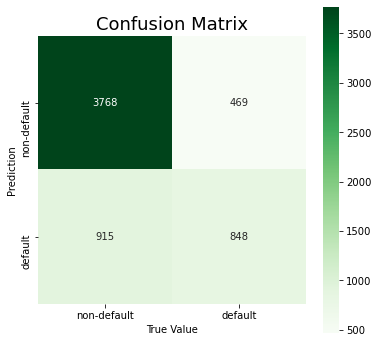

In [33]:
conf_mx = pd.crosstab(pred, y_test, rownames=['Prediction'], colnames=['True Value'])

plt.figure(figsize=(6,6))
sns.heatmap(conf_mx, annot=True, fmt='g', square=True,
            xticklabels=['non-default', 'default'],
           yticklabels=['non-default', 'default'],
           cmap="Greens")
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Feature Importance

The most important features are:

* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

This makes sense, since September is the most recent Month in the data, the ability to repay the bill in the previous month would be a good indicator of repayment in next month.

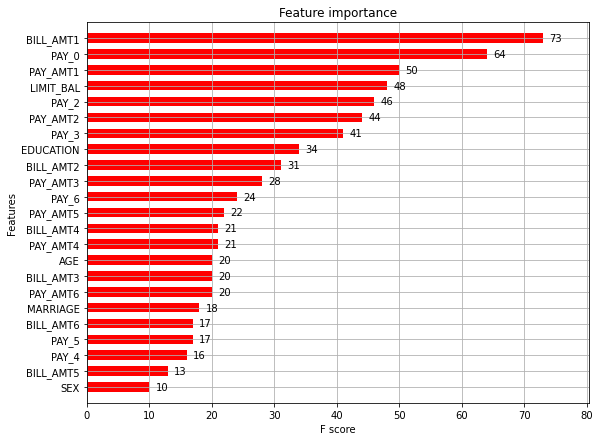

In [34]:
fig, ax = plt.subplots(figsize=(9,7))
xgb.plot_importance(model, height=0.6, ax=ax, color='red')
plt.show()

## 